In [183]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as sstat
from mpmath import mp
import math
import random

psd = pd.DataFrame
from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions

Generiamo 1000 sample da una normale:

\begin{equation*}
\begin{aligned}
    y_{obs} &\sim \mathcal{N}(\mu_{obs}, σ_{obs} ^2) \\
\end{aligned}
\end{equation*}

e scegliamo come modello:

\begin{equation*}
\begin{aligned}
    y_i | \mu &\sim ^{iid} \mathcal{N}(\mu, \sigma_{obs} ^2)  \\
    \mu & \sim \mathcal{N}(\mu_0, \sigma_0^2)
\end{aligned}
\end{equation*}

$\sigma_{obs}$ noto

$\mu_0, \sigma_0$ fissati

$\mathscr{L}(y_i|\mu)$:

In [184]:
def single_lik(mu):
   y= tfd.Normal(mu,sigma_obs)
   return y

# $\pi(\mu)$:

In [185]:
def prior():
    return tfd.Normal(mu0,sigma0)
    

proposal distribution $g(\theta'|\theta)$= $N(\theta, 1)$

In [186]:
def proposal(theta1):
  return tfd.Normal(theta1,4)

definiamo la funzione Kernel Gaussiana

In [187]:
def my_kernel(u):
  return 1/(np.sqrt(2*math.pi))*np.exp(-1/2*u**2)

In [188]:
def K_h(u,h):
  return my_kernel(u/h)/h

Come summary statistics utilizziamo:


*   Quantili
*   Media campionaria



In [189]:
def S1(y):
  quantiles=[]
  for i in range(9):
      quantiles.append(np.quantile(y,0.1+0.1*i))         #quantili 0,1 0,2 0,3 0,4 0,5 0,6 0,7 0,8 0,9
  return quantiles

In [190]:
def S2(y):
  return np.mean(y)

ABC algorithm:

In [191]:
def abc_algo (N, S, y_obs, h):
    s_obs = S(y_obs)
    theta=[]
    s = []
    y = []
    theta_0 = prior().sample()
    y_0 = single_lik(theta_0).sample() 
    s_0 = S(y_0)
    
    while K_h(np.linalg.norm(np.array(s_0)-np.array(s_obs)),h)<=0:
        theta_0 = prior().sample()
        y_0 = single_lik(theta_0).sample() 
        s_0 = S(y_0)
      
    theta.append(theta_0)
    s.append(s_0)
    y.append(y_0)
    theta_old = theta_0
    s_old = s_0
    y_old = y_0

    for i in range(N):
        theta_current = proposal(theta_old).sample()
        y_current = single_lik(theta_current).sample(1000)
        #y.append(y_current)
        s_current = S(y_current)
               
        prob = min([1.,(K_h(np.linalg.norm(np.array(s_current) - np.array(s_obs)),h)*prior().prob(theta_current)*proposal(theta_old).prob(theta_current))/(
             K_h(np.linalg.norm(np.array(s_old)-np.array(s_obs)),h)*prior().prob(theta_old)*proposal(theta_current).prob(theta_old))])
        u = tfd.Uniform(0,1).sample()
        if u < prob:
              theta_i = theta_current
              s_i = s_current
        else: 
              theta_i = theta_old
              s_i = s_old
              #y.pop()
              #y.append(y_old)

        theta_old = theta_i
        s_old = s_i
        
        theta.append(theta_i)
        s.append(s_i)
        
    return  theta

testiamo con le seguenti variabili:

In [192]:
##VARIABILI:
mu0 = 120
sigma0 = 4
n = 1000
mu_obs = 123
sigma_obs = 3
y_obs = tfp.distributions.Normal(mu_obs,sigma_obs).sample(1000)

In [208]:
prova = abc_algo (n, S2, y_obs, 0.2)   #passo h=0,4 con S1 (quantili) e h=0.2 con S2(media)

(array([ 10.,   0.,  13.,  23.,  65.,  41.,  67., 202.,  65., 185., 105.,
         13.,  89.,  16.,   4.,   7.,  11.,   5.]),
 array([122.2067  , 122.291985, 122.37726 , 122.46254 , 122.54782 ,
        122.6331  , 122.718376, 122.80366 , 122.88894 , 122.97421 ,
        123.059494, 123.144775, 123.23006 , 123.31533 , 123.40061 ,
        123.48589 , 123.571175, 123.65645 , 123.74173 ], dtype=float32),
 <a list of 18 Patch objects>)

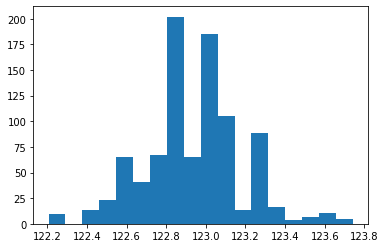

In [209]:
plt.hist(prova[80:],bins=18)

controlliamo il risultato plottando la posterior corretta

In [210]:
def real_posterior(mu0,n,y):
    y= tfd.Normal(1/(1/sigma0**2 + n/sigma_obs**2)*(mu0/sigma0**2 + (np.sum(y)/sigma_obs**2)),1/(1/sigma0**2 + n/sigma_obs**2))   
    return y

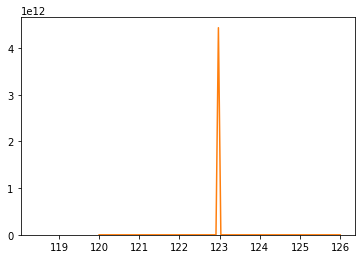

In [214]:
import scipy.stats as stats
x = np.linspace(mu_obs - 3*sigma_obs, mu_obs + 3*sigma_obs, 100)

plt.hist(prova)
plt.plot(x, 10*stats.norm.pdf(x,1/(1/sigma0**2 + n/sigma_obs**2)*(mu0/sigma0**2 + (np.sum(y_obs)/sigma_obs**2)), 1/(1/sigma0**2 + n/sigma_obs**2)))
plt.show()

MH restituisce delle μ sampled dalla prior e non dalla posterior 